In [178]:
!pip install folium

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.


In [179]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_936868e3b7a041a29ed5e6d8d6527c8e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='c75VEKJovc437dcCqrvx-o1BIBaBzO-f8dFNskMKpSDJ',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_936868e3b7a041a29ed5e6d8d6527c8e.get_object(Bucket='datascience-donotdelete-pr-dbwhvmvxvlzh9z',Key='listings_summary.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_listing_summ = pd.read_csv(body)

In [180]:
import seaborn as sns
import numpy as np
import matplotlib as mpl
from scipy.stats import norm
import scipy
import matplotlib.pyplot as plt
import folium
%matplotlib inline
pd.set_option('display.max_columns', 500)
mpl.style.use(['seaborn-darkgrid'])

In [181]:
df_listing_summ.shape

(22552, 96)

In [182]:
#ignore unwanted columns like URLs
columns_to_keep = ['id','host_has_profile_pic','host_since',
                   'description',
                   'latitude', 'longitude','is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'price', 'cleaning_fee',
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy','availability_365']
df_listing_summ = df_listing_summ[columns_to_keep].set_index('id')

In [183]:
df_listing_summ.shape

(22552, 23)

In [184]:
#Check null values in each column for further cleaning
df_listing_summ.isnull().sum()

host_has_profile_pic          26
host_since                    26
description                  203
latitude                       0
longitude                      0
is_location_exact              0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                     32
bedrooms                      18
bed_type                       0
amenities                      0
price                          0
cleaning_fee                7146
security_deposit            9361
extra_people                   0
guests_included                0
minimum_nights                 0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
availability_365               0
dtype: int64

In [185]:
#Convert f,t to 0 or 1
df_listing_summ['is_location_exact'] = df_listing_summ['is_location_exact'].map({'f':0,'t':1})
df_listing_summ['is_business_travel_ready'] = df_listing_summ['is_business_travel_ready'].map({'f':0,'t':1})
df_listing_summ['instant_bookable'] = df_listing_summ['instant_bookable'].map({'f':0,'t':1})

In [186]:
#fill f for N/A in host_has_profile_pic column for further correct mapping
set(df_listing_summ['host_has_profile_pic'])
df_listing_summ['host_has_profile_pic'].fillna('f',inplace=True)

In [187]:
#Convert f,t to 0 or 1
df_listing_summ['host_has_profile_pic'] = df_listing_summ['host_has_profile_pic'].map({'f':0,'t':1})

In [188]:
#Remove $ from price, fee columns and convert to float
df_listing_summ['price'] = df_listing_summ['price'].str.replace('$', '').str.replace(',', '').astype(float)
df_listing_summ['cleaning_fee'] = df_listing_summ['cleaning_fee'].str.replace('$', '').str.replace(',', '').astype(float)
df_listing_summ['security_deposit'] = df_listing_summ['security_deposit'].str.replace('$', '').str.replace(',', '').astype(float)
df_listing_summ['extra_people'] = df_listing_summ['extra_people'].str.replace('$', '').str.replace(',', '').astype(float)

In [189]:
#cleaning_fee cleanup of N/a replace with median value
df_listing_summ['cleaning_fee'].fillna(df_listing_summ['cleaning_fee'].median(), inplace=True)

In [190]:
#security_deposit cleanup of N/a replace with median value
df_listing_summ['security_deposit'].fillna(df_listing_summ['security_deposit'].median(), inplace=True)

In [191]:
#Check distribution of price column
df_listing_summ['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

As we see above 75% of prices are near 70 Euros , but min is 0 & max is 9000. Lets drop anything above 400

In [192]:
df_listing_summ.drop(df_listing_summ[ (df_listing_summ.price > 400) | (df_listing_summ.price == 0) ].index, axis=0, inplace=True)
df_listing_summ['price'].describe()

count    22441.000000
mean        57.584377
std         42.162006
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        400.000000
Name: price, dtype: float64

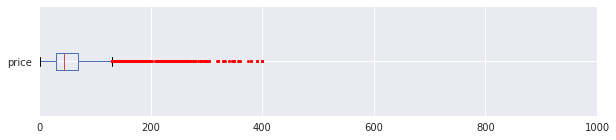

In [194]:
# boxplot of price column
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_listing_summ['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(10,2));

In [195]:
#cleanup bathroom , bedroom columns
df_listing_summ['bathrooms'].fillna(1,inplace=True)
df_listing_summ['bedrooms'].fillna(1,inplace=True)

# Display no. of rooms by type

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


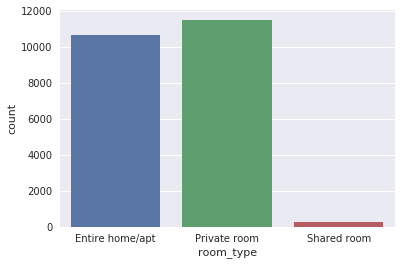

In [196]:
sns.countplot(x='room_type',data=df_listing_summ)

## Below indicates most no. of listings have a flexible cancellation policy

In [197]:
df_listing_summ['cancellation_policy'].value_counts()

flexible                       9051
moderate                       7075
strict_14_with_grace_period    6253
super_strict_30                  50
super_strict_60                  12
Name: cancellation_policy, dtype: int64

## Create new columns by parsing amenties

In [198]:
df_listing_summ['No_of_amentities'] = df_listing_summ['amenities'].apply(lambda x:len(x.split(',')))

In [199]:
df_listing_summ['Laptop_friendly_workspace'] = df_listing_summ['amenities'].str.contains('Laptop friendly workspace')
df_listing_summ['TV'] = df_listing_summ['amenities'].str.contains('TV')
df_listing_summ['Family_kid_friendly'] = df_listing_summ['amenities'].str.contains('Family/kid friendly')
df_listing_summ['Host_greets_you'] = df_listing_summ['amenities'].str.contains('Host greets you')
df_listing_summ['Smoking_allowed'] = df_listing_summ['amenities'].str.contains('Smoking allowed')
df_listing_summ['Hot_water'] = df_listing_summ['amenities'].str.contains('Hot water')
df_listing_summ['Fridge'] = df_listing_summ['amenities'].str.contains('Refrigerator')

In [200]:
#dropping amenities as we have inferred above as different categories
dropped = ['amenities']
df_listing_summ.drop(dropped,axis=1,inplace=True)

In [208]:
df = df_listing_summ[['Laptop_friendly_workspace','TV','Family_kid_friendly','Hot_water','Fridge','Smoking_allowed']]
#sns.countplot(x='room_type',data=df)

In [201]:
from math import sin, cos, sqrt, atan2, radians

In [202]:
#Calculate distance from central berlin
def haversine_distance_central(row):
    berlin_lat,berlin_long = radians(52.5200), radians(13.4050)
    R = 6373.0
    long = radians(row['longitude'])
    lat = radians(row['latitude'])
    
    dlon = long - berlin_long
    dlat = lat - berlin_lat
    a = sin(dlat / 2)**2 + cos(lat) * cos(berlin_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [26]:
#Calculate distance from airport
def haversine_distance_airport(row):
    berlin_lat,berlin_long = radians(52.3733), radians(13.5064)
    R = 6373.0
    long = radians(row['longitude'])
    lat = radians(row['latitude'])
    
    dlon = long - berlin_long
    dlat = lat - berlin_lat
    a = sin(dlat / 2)**2 + cos(lat) * cos(berlin_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [27]:
#Calculate distance from berlin railway station
def haversine_distance_rail(row):
    berlin_lat,berlin_long = radians(52.5073), radians(13.3324)
    R = 6373.0
    long = radians(row['longitude'])
    lat = radians(row['latitude'])
    
    dlon = long - berlin_long
    dlat = lat - berlin_lat
    a = sin(dlat / 2)**2 + cos(lat) * cos(berlin_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [28]:
df_listing_summ['distance_central'] = df_listing_summ.apply(haversine_distance_central,axis=1)
df_listing_summ['distance_airport'] = df_listing_summ.apply(haversine_distance_airport,axis=1)
df_listing_summ['distance_railways'] = df_listing_summ.apply(haversine_distance_rail,axis=1)
df_listing_summ['distance_avg'] = ( df_listing_summ['distance_central'] + df_listing_summ['distance_airport'] + df_listing_summ['distance_railways'] )/3.0

In [29]:
df_listing_summ['distance_avg'].describe()

count    22387.000000
mean         9.406266
std          1.791556
min          7.499669
25%          8.286350
50%          9.004726
75%          9.959958
max         24.636447
Name: distance_avg, dtype: float64

In [30]:
df_listing_summ.head()

,host_has_profile_pic,host_since,description,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,availability_365,No_of_amentities,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed,Hot_water,Fridge,distance_central,distance_airport,distance_railways,distance_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015,1,2008-08-18,Great location! 30 of 75 sq meters. This wood...,52.534537,13.402557,0,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,60.0,30.0,200.0,28.0,1,4,0,0,strict_14_with_grace_period,141,29,True,True,True,False,False,True,True,1.625414,19.266232,5.632427,8.841357
2695,1,2008-09-16,In the summertime we are spending most of our ...,52.548513,13.404553,1,Apartment,Private room,2,1.0,1.0,Real Bed,17.0,0.0,0.0,0.0,1,2,0,0,flexible,0,10,True,False,False,False,False,False,False,3.171617,20.675116,6.697246,10.181326
3176,1,2008-10-19,This beautiful first floor apartment is situa...,52.534996,13.417579,1,Apartment,Entire home/apt,4,1.0,1.0,Real Bed,90.0,50.0,200.0,20.0,2,62,1,0,strict_14_with_grace_period,220,19,True,False,True,False,False,False,False,1.872657,18.966373,6.536374,9.125135
3309,1,2008-11-07,First of all: I prefer short-notice bookings. ...,52.498855,13.349065,1,Apartment,Private room,2,1.0,1.0,Pull-out Sofa,26.0,30.0,250.0,18.0,1,5,0,0,strict_14_with_grace_period,297,29,True,False,False,True,False,True,False,4.457682,17.574477,1.468150,7.833436
7071,1,2009-05-16,Cozy and large room in the beautiful district ...,52.543157,13.415091,1,Apartment,Private room,2,1.0,1.0,Real Bed,42.0,0.0,0.0,24.0,1,2,0,0,moderate,26,13,True,False,True,False,False,True,False,2.664743,19.880937,6.871866,9.805849


In [31]:
df_listing_summ.sort_values(by='price',ascending=False,axis=0,inplace=True) #sorting frame by price desc

In [32]:
df_list_summ_top10000 = df_listing_summ.head(10000)
df_list_summ_top500 = df_listing_summ.head(500)

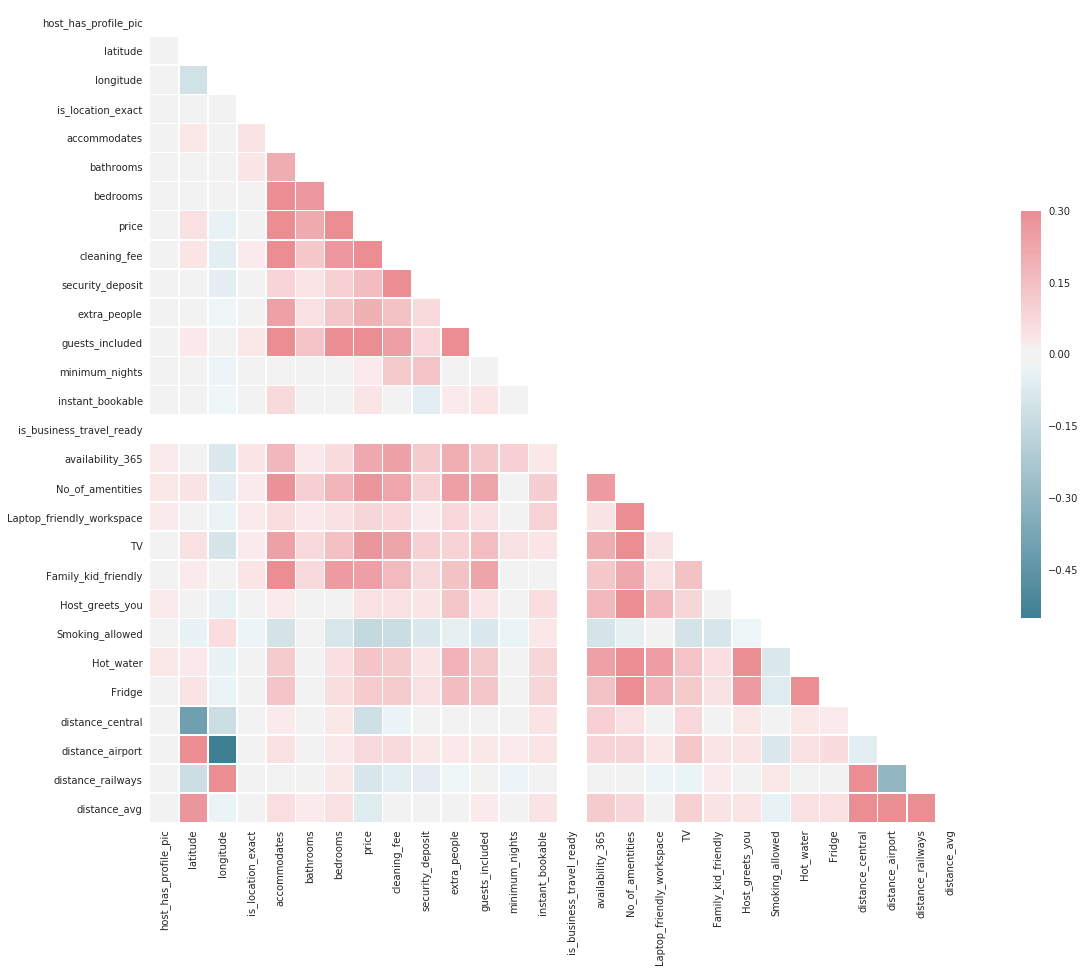

In [33]:
sns.set(style="white")
corr = df_listing_summ.corr()

# generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 15))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink":.5},cbar=True);

## Price seems to depend on following factors
* No. of ameneties
* Is it family or kids friendly
* Cleaning fee
* Capacity i.e how many guests it can accomodate

In [34]:
lat = 52.509
long = 13.381
base = folium.Map(location=[lat,long], zoom_start=12) #base map setting
base

In [35]:
neighbourhoods = folium.map.FeatureGroup()

In [36]:
#central berlin location
inc_lat=52.520
inc_long=13.405
neighbourhoods.add_child(
folium.CircleMarker(
[inc_lat,inc_long],
radius = 14,
color='yellow',
fill=True,
fill_color='red',
fill_opacity=0.6
)
)
base.add_child(neighbourhoods)

In [37]:
#airport location
inc_lat=52.373
inc_long=13.506
neighbourhoods.add_child(
folium.CircleMarker(
[inc_lat,inc_long],
radius = 14,
color='yellow',
fill=True,
fill_color='green',
fill_opacity=0.6
)
)
base.add_child(neighbourhoods)

In [38]:
#railway station location
inc_lat=52.507
inc_long=13.332
neighbourhoods.add_child(
folium.CircleMarker(
[inc_lat,inc_long],
radius = 14,
color='yellow',
fill=True,
fill_color='black',
fill_opacity=0.6
)
)
base.add_child(neighbourhoods)

In [39]:
neighbourhoods = folium.map.FeatureGroup()
for inc_lat,inc_long in zip(df_list_summ_top500.longitude,df_list_summ_top500.latitude):
    neighbourhoods.add_child(
    folium.CircleMarker(
    [inc_long,inc_lat],
    radius = 5,
    color='yellow',
    fill=True,
    fill_color='blue',
    fill_opacity=0.6
    )
)
base.add_child(neighbourhoods)

## This means top 500 properties are around central berlin & railway station & very few near airport

In [152]:
body = client_936868e3b7a041a29ed5e6d8d6527c8e.get_object(Bucket='datascience-donotdelete-pr-dbwhvmvxvlzh9z',Key='reviews_summary.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_review_summ = pd.read_csv(body)
df_review_summ.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2015,69544350,2016-04-11,7178145,Rahel,Mein Freund und ich hatten gute gemütliche vie...
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...
2,2015,71605267,2016-04-26,30048708,Victor,Un appartement tres bien situé dans un quartie...
3,2015,73819566,2016-05-10,63697857,Judy,"It is really nice area, food, park, transport ..."
4,2015,74293504,2016-05-14,10414887,Romina,"Buena ubicación, el departamento no está orden..."


In [153]:
df_review_summ.drop(['reviewer_id', 'reviewer_name', 'comments'], axis=1, inplace=True)

In [154]:
# rename id column and replace current value simply with 1 to later count the # of reviews per accommodation per month
df_review_summ.rename({'id':'review_count'}, axis=1, inplace=True)
df_review_summ.review_count = 1

In [155]:
#casting date to date type
df_review_summ.date = pd.to_datetime(df_review_summ.date, format="%Y-%m-%d")

In [156]:
#add year & month columns
df_review_summ['year'] = pd.DatetimeIndex(df_review_summ['date']).year
df_review_summ['month'] = pd.DatetimeIndex(df_review_summ['date']).month

In [157]:
#splitting data by date
condition = df_review_summ["date"].isin(pd.date_range('2018-01-01', '2018-10-31'))
count_2018 = df_review_summ[condition]
condition = df_review_summ["date"].isin(pd.date_range('2017-01-01', '2017-12-31'))
count_2017 = df_review_summ[condition]
condition = df_review_summ["date"].isin(pd.date_range('2016-01-01', '2016-12-31'))
count_2016 = df_review_summ[condition]
condition = df_review_summ["date"].isin(pd.date_range('2015-01-01', '2015-12-31'))
count_2015 = df_review_summ[condition]

In [158]:
# set the date as index and sort by index
count_2018 = count_2018.set_index('date').sort_index()
count_2017 = count_2017.set_index('date').sort_index()
count_2016 = count_2016.set_index('date').sort_index()
count_2015 = count_2015.set_index('date').sort_index()

In [159]:
# calculate reviews per month for each year range
count_2018_mthnly = count_2018.groupby([pd.TimeGrouper(freq='M'),'listing_id'])['review_count'].agg({'review_count':{'reviews_per_month_18':'count'}}).reset_index()
count_2018_mthnly.columns = ['date', 'listing_id', 'reviews_per_month_18']

count_2017_mthnly = count_2017.groupby([pd.TimeGrouper(freq='M'),'listing_id'])['review_count'].agg({'review_count':{'reviews_per_month_17':'count'}}).reset_index()
count_2017_mthnly.columns = ['date', 'listing_id', 'reviews_per_month_17']

count_2016_mthnly = count_2016.groupby([pd.TimeGrouper(freq='M'),'listing_id'])['review_count'].agg({'review_count':{'reviews_per_month_16':'count'}}).reset_index()
count_2016_mthnly.columns = ['date', 'listing_id', 'reviews_per_month_16']

count_2015_mthnly = count_2015.groupby([pd.TimeGrouper(freq='M'),'listing_id'])['review_count'].agg({'review_count':{'reviews_per_month_15':'count'}}).reset_index()
count_2015_mthnly.columns = ['date', 'listing_id', 'reviews_per_month_15']

# set date as index
count_2018_mthnly.set_index('date', inplace=True)
count_2017_mthnly.set_index('date', inplace=True)
count_2016_mthnly.set_index('date', inplace=True)
count_2015_mthnly.set_index('date', inplace=True)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  from ipykernel import kernelapp as app
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/groupby.py:3098: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  results[name] = obj.aggregate(func)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: using a dict on a Series for aggregat

Text(0.04,0.5,'Average Reviews per Month')

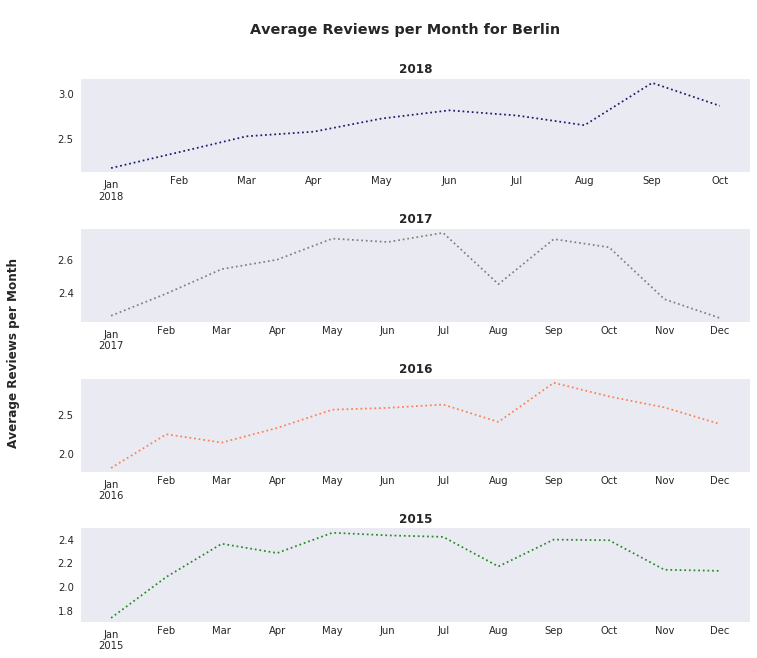

In [160]:
sns.set(style="dark")
fig, axes = plt.subplots(4, 1, figsize=(12,10))

sub_1 = count_2018_mthnly.groupby('date')['reviews_per_month_18'].mean()
sub_1.plot(ax=axes[0], color='midnightblue', style=':')
axes[0].set_title('2018', fontweight='bold')
axes[0].set_xlabel('') 

sub_2 = count_2017_mthnly.groupby('date')['reviews_per_month_17'].mean()
sub_2.plot(ax=axes[1], color='grey', style=':')
axes[1].set_title('2017', fontweight='bold')
axes[1].set_xlabel('') 

sub_3 = count_2016_mthnly.groupby('date')['reviews_per_month_16'].mean()
sub_3.plot(ax=axes[2], color='coral', style=':')
axes[2].set_title('2016', fontweight='bold')
axes[2].set_xlabel('') 

sub_4 = count_2015_mthnly.groupby('date')['reviews_per_month_15'].mean()
sub_4.plot(ax=axes[3], color='forestgreen', style=':')
axes[3].set_title('2015', fontweight='bold')
axes[3].set_xlabel('') 

# adjust space between subplots and set a title
plt.subplots_adjust(hspace = 0.6)
plt.suptitle('\nAverage Reviews per Month for Berlin\n', fontweight='bold')

# plot common y-label
fig.text(0.04, 0.5, 'Average Reviews per Month', fontweight='bold', va='center', rotation='vertical')

## This means between APR-JUL we have most no. of visitors; then it drops and again peaks in Sep,Oct